# **Building an NLP-Based Sentiment Analysis and Text Generation System Using Deep Learning**

## **Task 1: Data Preprocessing and Word Embeddings**

### Import of Libraries and Loading of dataset by path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec, FastText

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('/Users/asanali.tokenov/Desktop/midterm /Reviews.csv')

print("Dataset Shape:", df.shape)
print(df.head())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asanali.tokenov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asanali.tokenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/asanali.tokenov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Shape: (568454, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of t

### Preprocess of the text

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and non-alphabets
    tokens = word_tokenize(text)  # tokenize
    # Remove stopwords and lemmatize token
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return cleaned_tokens

df['processed_text'] = df['Text'].astype(str).apply(preprocess_text)

print("Original Text:", df['Text'].iloc[0])
print("Processed Tokens:", df['processed_text'].iloc[0])


Original Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Processed Tokens: ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'product', 'found', 'good', 'quality', 'product', 'look', 'like', 'stew', 'processed', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [4]:
corpus = df['processed_text'].dropna().tolist()

print("Number of documents in corpus:", len(corpus))


Number of documents in corpus: 568454


### Building Word Embeddings

### *Train Word2Vec and FastText*

In [ ]:
# CBOW model
w2v_cbow = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, sg=0, workers=4)
# Skip-gram model
w2v_skipgram = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, sg=1, workers=4)
#FastText model
ft_model = FastText(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4)

print("Word2Vec CBOW vocabulary size:", len(w2v_cbow.wv))
print("Word2Vec Skip-gram vocabulary size:", len(w2v_skipgram.wv))
print("FastText vocabulary size:", len(ft_model.wv))


Word2Vec CBOW vocabulary size: 52656
Word2Vec Skip-gram vocabulary size: 52656
FastText vocabulary size: 52656


### *Evaluate the embeddings using cosine similarity and visualize the embeddings using t-SNE and PCA.*

Number of words to visualize: 1000


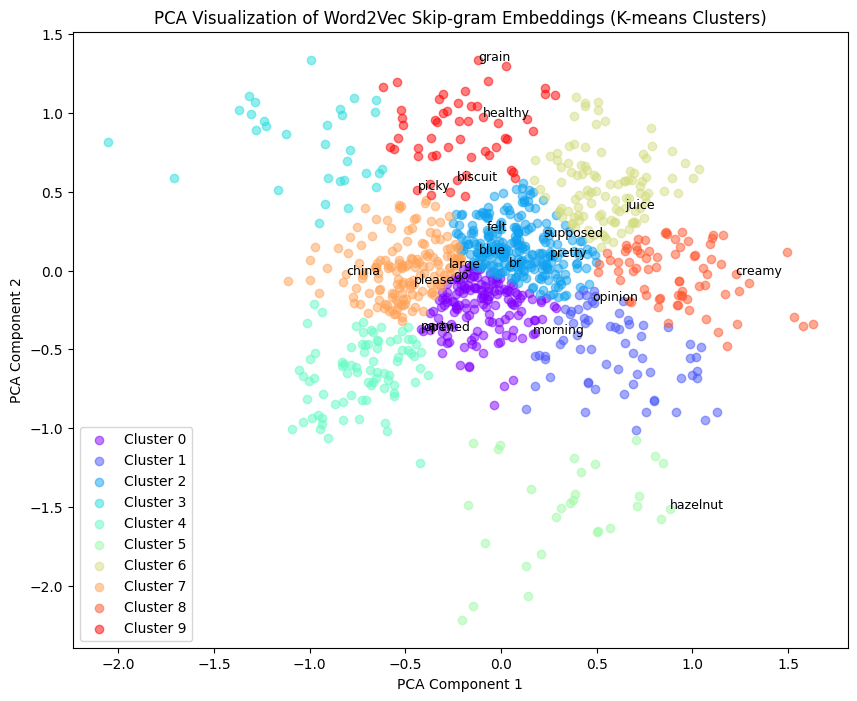

/Users/asanali.tokenov/Desktop/midterm /venv_py311/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


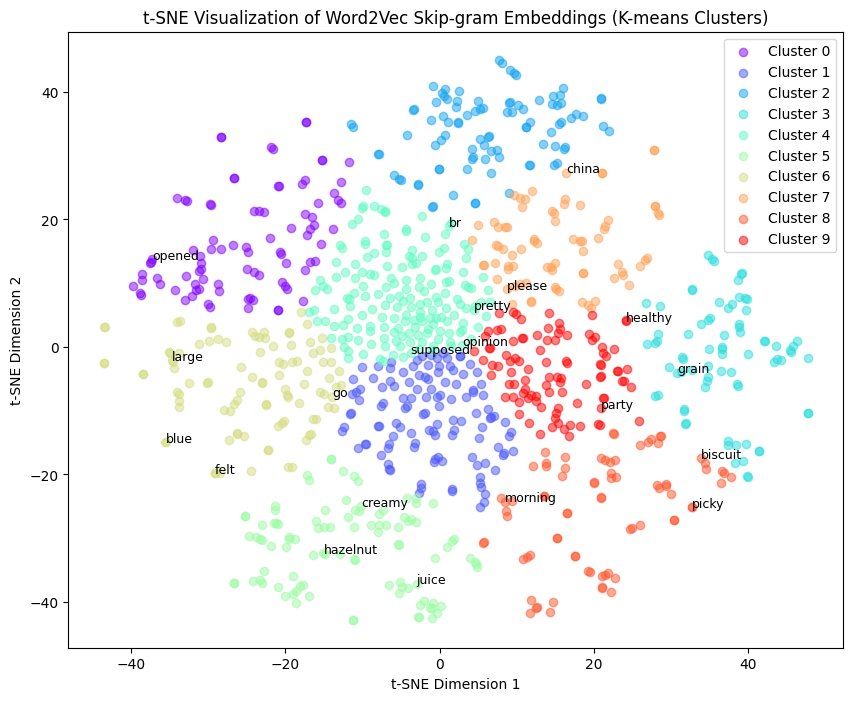

In [ ]:
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.cm as cm

all_words = [word for tokens in corpus for word in tokens]
word_freq = Counter(all_words)

top_words = [word for word, freq in word_freq.most_common(1000)]

words_to_visualize = [word for word in top_words if word in w2v_skipgram.wv.key_to_index]
print("Number of words to visualize:", len(words_to_visualize))

word_vectors = np.array([w2v_skipgram.wv[word] for word in words_to_visualize])

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(word_vectors)

num_clusters = 10 
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42)
labels_pca = kmeans_pca.fit_predict(pca_result)

colors = cm.rainbow(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_indices = np.where(labels_pca == cluster_id)[0]
    
    plt.scatter(
        pca_result[cluster_indices, 0],
        pca_result[cluster_indices, 1],
        color=colors[cluster_id],
        alpha=0.5,
        label=f"Cluster {cluster_id}"
    )

for i in range(0, len(words_to_visualize), 50):  # step by 50
    plt.annotate(
        words_to_visualize[i],
        xy=(pca_result[i, 0], pca_result[i, 1]),
        fontsize=9
    )

plt.title("PCA Visualization of Word2Vec Skip-gram Embeddings (K-means Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(word_vectors)

# Clustering in 2D t-SNE space
kmeans_tsne = KMeans(n_clusters=num_clusters, random_state=42)
labels_tsne = kmeans_tsne.fit_predict(tsne_result)

# Plot t-SNE with color‐coded clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_indices = np.where(labels_tsne == cluster_id)[0]
    plt.scatter(
        tsne_result[cluster_indices, 0],
        tsne_result[cluster_indices, 1],
        color=colors[cluster_id],
        alpha=0.5,
        label=f"Cluster {cluster_id}"
    )

for i in range(0, len(words_to_visualize), 50):
    plt.annotate(
        words_to_visualize[i],
        xy=(tsne_result[i, 0], tsne_result[i, 1]),
        fontsize=9
    )

plt.title("t-SNE Visualization of Word2Vec Skip-gram Embeddings (K-means Clusters)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


## **Task 2: Building Recurrent Neural Networks for Sentiment Analysis**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [ ]:


df = df.dropna(subset=['Score', 'processed_text'])

def encode_sentiment(score):
    return 1 if score >= 4 else 0

df['sentiment'] = df['Score'].apply(encode_sentiment)

print("Distribution of labels:")
print(df['sentiment'].value_counts())

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
print("Train size:", len(train_df), "Test size:", len(test_df))


Distribution of labels:
sentiment
1    443777
0    124677
Name: count, dtype: int64
Train size: 454763 Test size: 113691


In [ ]:
w2v_model = w2v_skipgram
embedding_dim = w2v_model.vector_size

from collections import defaultdict

word_index = {} 
index = 1   
for tokens in train_df['processed_text']:
    for token in tokens:
        if token not in word_index:
            word_index[token] = index
            index += 1

vocab_size = len(word_index)
print("Vocabulary size (training set):", vocab_size)

embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print("Embedding matrix shape:", embedding_matrix.shape)


Vocabulary size (training set): 190817
Embedding matrix shape: (190818, 100)


In [ ]:
def convert_tokens_to_ids(tokens, word2idx):
    return [word2idx[token] for token in tokens if token in word2idx]

X_train = [convert_tokens_to_ids(tokens, word_index) for tokens in train_df['processed_text']]
X_test = [convert_tokens_to_ids(tokens, word_index) for tokens in test_df['processed_text']]

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

max_length = 100
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

print("X_train shape:", X_train_padded.shape)
print("X_test shape:", X_test_padded.shape)


X_train shape: (454763, 100)
X_test shape: (113691, 100)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    ),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()


/Users/asanali.tokenov/Desktop/midterm /venv_py311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    19,081,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,081,800 (72.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,081,800 (72.79 MB)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test))
test_dataset = test_dataset.batch(64)

model_custom = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    ),
    tf.keras.layers.SimpleRNN(64, return_sequences=False, name='simple_rnn'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output_dense')
])

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_loss_results = []
train_accuracy_results = []
rnn_gradients_log = []

EPOCHS = 5

for epoch in range(EPOCHS):
    epoch_loss = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.BinaryAccuracy()

 
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model_custom(x_batch, training=True)
            loss_value = loss_fn(y_batch, logits)
        
        grads = tape.gradient(loss_value, model_custom.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_custom.trainable_variables))
        
        epoch_loss.update_state(loss_value)
        epoch_accuracy.update_state(y_batch, logits)
        
        for var, grad in zip(model_custom.trainable_variables, grads):
            if "simple_rnn" in var.name and "kernel:0" in var.name:
                rnn_gradients_log.append(tf.norm(grad).numpy())
                break 

    train_loss_results.append(epoch_loss.result().numpy())
    train_accuracy_results.append(epoch_accuracy.result().numpy())
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss.result():.4f} - Accuracy: {epoch_accuracy.result():.4f}")

print("Training completed.")


2025-03-04 16:06:10.529596: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/5 - Loss: 0.4814 - Accuracy: 0.7928


2025-03-04 16:15:14.975562: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/5 - Loss: 0.3741 - Accuracy: 0.8368
Epoch 3/5 - Loss: 0.5256 - Accuracy: 0.7808


2025-03-04 16:33:06.260949: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/5 - Loss: 0.5192 - Accuracy: 0.7815
Epoch 5/5 - Loss: 0.4961 - Accuracy: 0.7837
Training completed.


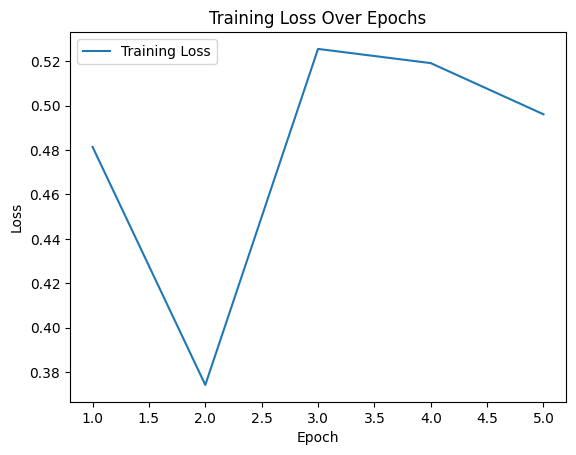

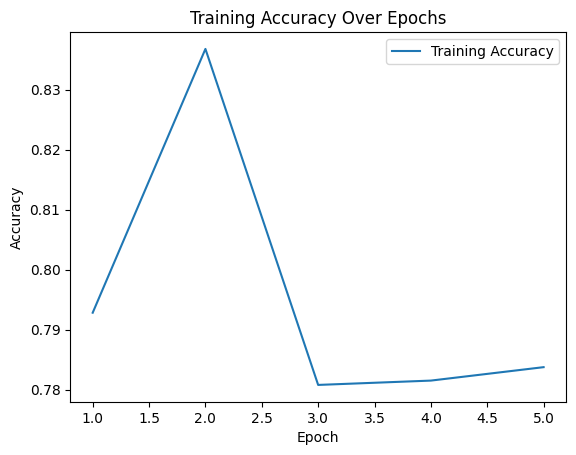

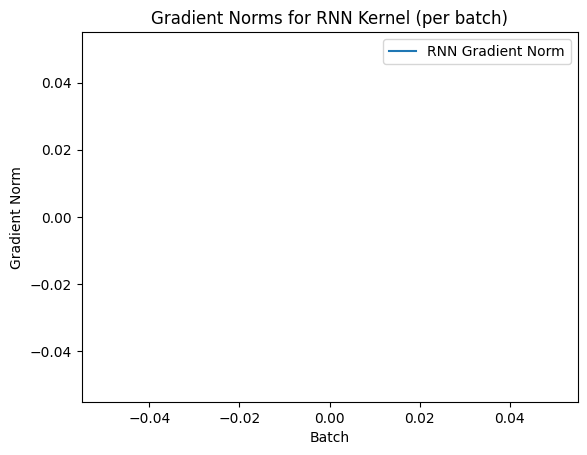

In [ ]:
epochs_range = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs_range, train_loss_results, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, train_accuracy_results, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(rnn_gradients_log, label='RNN Gradient Norm')
plt.title('Gradient Norms for RNN Kernel (per batch)')
plt.xlabel('Batch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()


## **Task 3: Implementing LSTM and GRU for Text Classification**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
lstm_model = Sequential()
lstm_model.add(
    Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False 
    )
)
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

lstm_model.summary()

batch_size = 64
epochs = 5 

start_time = time.time()
lstm_history = lstm_model.fit(
    X_train_padded,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)
end_time = time.time()
lstm_training_time = end_time - start_time

print(f"LSTM Training completed in {lstm_training_time:.2f} seconds.")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    19,081,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,081,800 (72.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,081,800 (72.79 MB)

Epoch 1/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 132s 23ms/step - accuracy: 0.8192 - loss: 0.4326 - val_accuracy: 0.8807 - val_loss: 0.2794
Epoch 2/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 121s 21ms/step - accuracy: 0.8822 - loss: 0.2783 - val_accuracy: 0.8889 - val_loss: 0.2619
Epoch 3/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 121s 21ms/step - accuracy: 0.8909 - loss: 0.2594 - val_accuracy: 0.8899 - val_loss: 0.2591
Epoch 4/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 119s 21ms/step - accuracy: 0.8983 - loss: 0.2432 - val_accuracy: 0.8999 - val_loss: 0.2395
Epoch 5/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 130s 23ms/step - accuracy: 0.9056 - loss: 0.2290 - val_accuracy: 0.9040 - val_loss: 0.2317
LSTM Training completed in 623.88 seconds.


In [ ]:
gru_model = Sequential()
gru_model.add(
    Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )
)
gru_model.add(GRU(64))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

gru_model.summary()

start_time = time.time()
gru_history = gru_model.fit(
    X_train_padded,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)
end_time = time.time()
gru_training_time = end_time - start_time

print(f"GRU Training completed in {gru_training_time:.2f} seconds.")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    19,081,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,081,800 (72.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,081,800 (72.79 MB)

Epoch 1/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - accuracy: 0.7992 - loss: 0.4816 - val_accuracy: 0.8795 - val_loss: 0.2855
Epoch 2/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 111s 19ms/step - accuracy: 0.8810 - loss: 0.2812 - val_accuracy: 0.8903 - val_loss: 0.2597
Epoch 3/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 120s 21ms/step - accuracy: 0.8921 - loss: 0.2563 - val_accuracy: 0.8984 - val_loss: 0.2443
Epoch 4/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 108s 19ms/step - accuracy: 0.9020 - loss: 0.2365 - val_accuracy: 0.9035 - val_loss: 0.2331
Epoch 5/5
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - accuracy: 0.9093 - loss: 0.2207 - val_accuracy: 0.9062 - val_loss: 0.2271
GRU Training completed in 555.95 seconds.


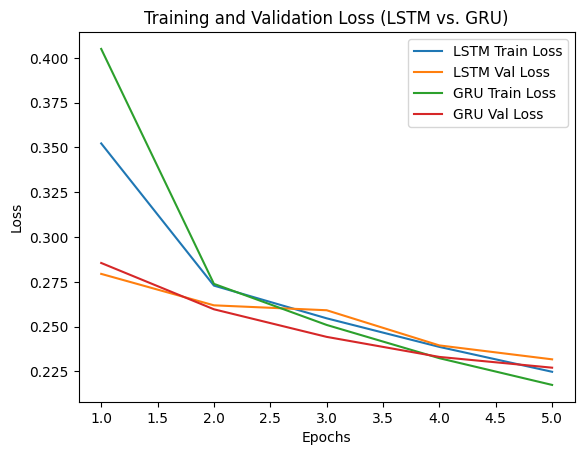

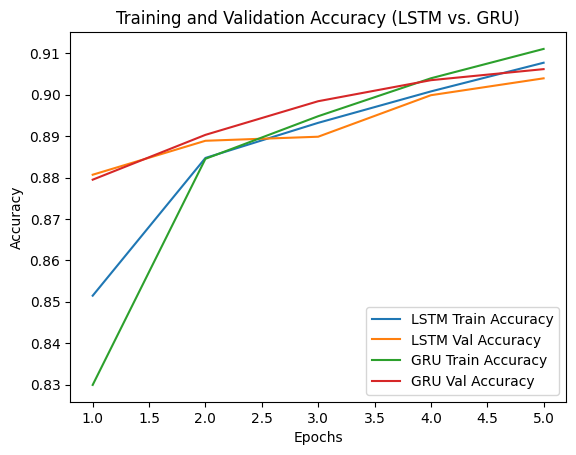

In [ ]:

lstm_train_loss = lstm_history.history['loss']
lstm_val_loss = lstm_history.history['val_loss']
lstm_train_acc = lstm_history.history['accuracy']
lstm_val_acc = lstm_history.history['val_accuracy']

gru_train_loss = gru_history.history['loss']
gru_val_loss = gru_history.history['val_loss']
gru_train_acc = gru_history.history['accuracy']
gru_val_acc = gru_history.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.figure()
plt.plot(epochs_range, lstm_train_loss, label='LSTM Train Loss')
plt.plot(epochs_range, lstm_val_loss, label='LSTM Val Loss')
plt.plot(epochs_range, gru_train_loss, label='GRU Train Loss')
plt.plot(epochs_range, gru_val_loss, label='GRU Val Loss')
plt.title('Training and Validation Loss (LSTM vs. GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, lstm_train_acc, label='LSTM Train Accuracy')
plt.plot(epochs_range, lstm_val_acc, label='LSTM Val Accuracy')
plt.plot(epochs_range, gru_train_acc, label='GRU Train Accuracy')
plt.plot(epochs_range, gru_val_acc, label='GRU Val Accuracy')
plt.title('Training and Validation Accuracy (LSTM vs. GRU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_padded, y_test, verbose=0)
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_padded, y_test, verbose=0)

print("=== LSTM Performance ===")
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")
print(f"LSTM Training Time: {lstm_training_time:.2f} seconds")

print("\n=== GRU Performance ===")
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")
print(f"GRU Training Time: {gru_training_time:.2f} seconds")


=== LSTM Performance ===
LSTM Test Loss: 0.2302
LSTM Test Accuracy: 0.9053
LSTM Training Time: 623.88 seconds

=== GRU Performance ===
GRU Test Loss: 0.2235
GRU Test Accuracy: 0.9093
GRU Training Time: 555.95 seconds


## **Task 4: Text Generation with LSTM**

Subset size: 5000
Corpus length (characters): 2147949
Actual vocab size (from tokenizer): 15184
Capped total_words for embedding: 5001
Length of the tokenized corpus: 386357
Number of (input→target) sequences: 386352
X shape: (386352, 5) | y shape: (386352, 5001)

Model Summary:


/Users/asanali.tokenov/Desktop/midterm /venv_py311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
6037/6037 ━━━━━━━━━━━━━━━━━━━━ 94s 15ms/step - accuracy: 0.0583 - loss: 6.2372
Epoch 2/5
6037/6037 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - accuracy: 0.1294 - loss: 5.3464
Epoch 3/5
6037/6037 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - accuracy: 0.1482 - loss: 5.0641
Epoch 4/5
6037/6037 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - accuracy: 0.1600 - loss: 4.8859
Epoch 5/5
6037/6037 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.1661 - loss: 4.7628


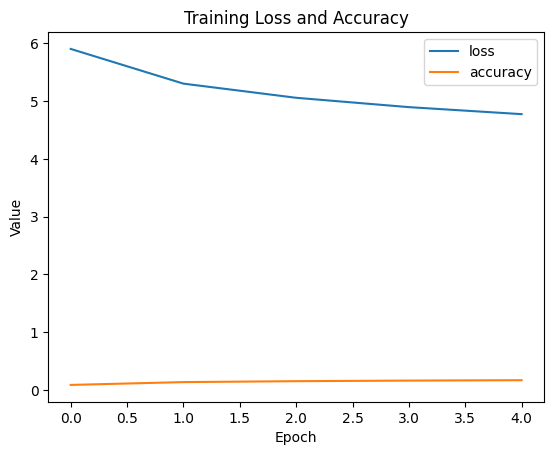

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

df_subset = df.sample(n=5000, random_state=42)
corpus_text = ' '.join(df_subset['Text'].astype(str).tolist())

if not corpus_text.strip():
    raise ValueError("The text corpus is empty. Please use a bigger subset or check your dataset.")

print("Subset size:", len(df_subset))
print("Corpus length (characters):", len(corpus_text))

# Tokenize
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts([corpus_text])

vocab_size = len(tokenizer.word_index)  # unique words discovered
max_vocab = 5000
total_words = min(vocab_size, max_vocab) + 1  # +1 for reserved index=0

print("Actual vocab size (from tokenizer):", vocab_size)
print("Capped total_words for embedding:", total_words)

if total_words <= 1:
    raise ValueError("No valid words found in the corpus. Increase your subset or check if your data is valid.")

corpus_sequence = tokenizer.texts_to_sequences([corpus_text])[0]
print("Length of the tokenized corpus:", len(corpus_sequence))

if len(corpus_sequence) < 2:
    raise ValueError("Corpus is too short (less than 2 tokens). Try a bigger subset or different data.")

n_gram_length = 5

sequences = []
for i in range(n_gram_length, len(corpus_sequence)):
    seq_input = corpus_sequence[i - n_gram_length : i]
    seq_target = corpus_sequence[i]
    sequences.append(seq_input + [seq_target])

if not sequences:
    raise ValueError(f"No sequences generated with n_gram_length={n_gram_length}. The corpus might be too small.")

sequences = np.array(sequences)
print("Number of (input→target) sequences:", len(sequences))

X = sequences[:, :-1] 
y = sequences[:, -1]  

y = tf.keras.utils.to_categorical(y, num_classes=total_words)
print("X shape:", X.shape, "| y shape:", y.shape)

if X.shape[0] == 0:
    raise ValueError("No valid training samples. Possibly n_gram_length is too large or data is too small.")

EMBED_DIM = 128
LSTM_UNITS = 256
DENSE_UNITS = 128
DROPOUT_RATE = 0.2
LEARNING_RATE = 1e-3

model = Sequential()

model.add(
    Embedding(
        input_dim=total_words,
        output_dim=EMBED_DIM,
        input_length=n_gram_length
    )
)

model.add(LSTM(LSTM_UNITS, return_sequences=True))
model.add(Dropout(DROPOUT_RATE))
model.add(LSTM(LSTM_UNITS))
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(DENSE_UNITS, activation='relu'))

model.add(Dense(total_words, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()

# Training
epochs = 5
batch_size = 64

history = model.fit(
    X,
    y,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()



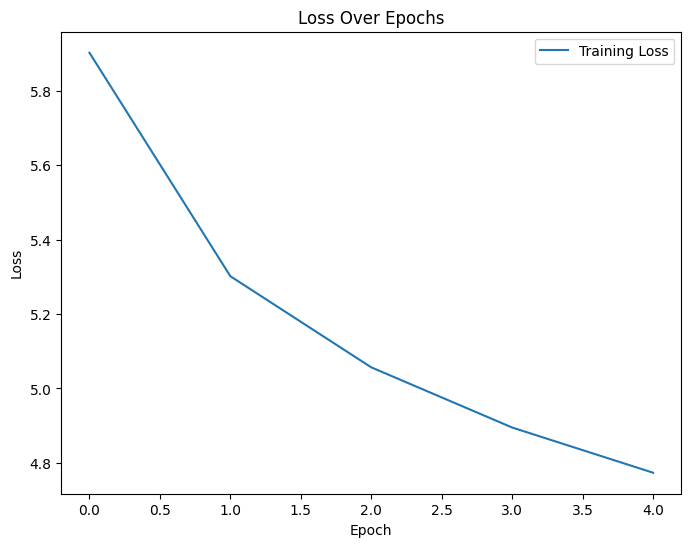

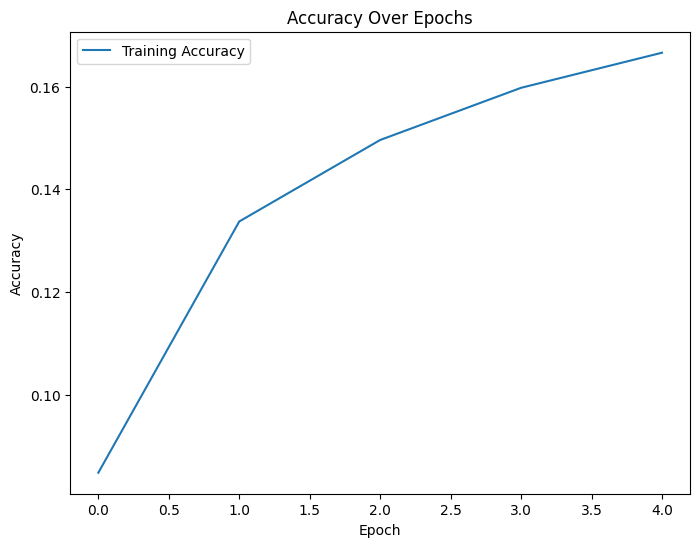

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
   
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_curves(history)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sample_from_probs(prob_dist, temperature=1.0):
    if temperature <= 0.0:
        return np.argmax(prob_dist)
    prob_dist = np.log(prob_dist + 1e-7) / temperature
    exp_probs = np.exp(prob_dist)
    prob_dist = exp_probs / np.sum(exp_probs)

    return np.random.choice(len(prob_dist), p=prob_dist)


In [ ]:
def generate_text(
    model, 
    tokenizer, 
    seed_text, 
    n_gram_length, 
    next_words=20, 
    temperature=1.0
):
    
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    for _ in range(next_words):
        token_list_padded = pad_sequences([token_list], maxlen=n_gram_length, padding='pre')
        
        predicted_probs = model.predict(token_list_padded, verbose=0)[0]
        
        predicted_word_index = sample_from_probs(predicted_probs, temperature)
        
        token_list.append(predicted_word_index)
    
    generated_sequence = tokenizer.sequences_to_texts([token_list])[0]
    return generated_sequence


In [ ]:
seeds = [
    "i love this",
    "the product is",
    "this restaurant has",
]

for seed in seeds:
    for temp in [0.0, 0.7, 1.0, 1.2]:
        generated = generate_text(
            model=model,
            tokenizer=tokenizer,
            seed_text=seed,
            n_gram_length=n_gram_length,
            next_words=15,
            temperature=temp
        )
        print(f"Seed: '{seed}' | Temperature: {temp}")
        print("Generated:", generated)
        print("-" * 50)
    print("=" * 50)


Seed: 'i love this' | Temperature: 0.0
Generated: i love this product and i have been using this product to the same time i have been
--------------------------------------------------
Seed: 'i love this' | Temperature: 0.7
Generated: i love this tea and it was up i will buy more at least so they are made
--------------------------------------------------
Seed: 'i love this' | Temperature: 1.0
Generated: i love this product and bake it down my search at my own using eight oz to 3
--------------------------------------------------
Seed: 'i love this' | Temperature: 1.2
Generated: i love this food like delicious volume to make a tradition or added simple better or shake red
--------------------------------------------------
Seed: 'the product is' | Temperature: 0.0
Generated: the product is a little better than the other brands i have ever had i have been using
--------------------------------------------------
Seed: 'the product is' | Temperature: 0.7
Generated: the product is a good al

## **Task 5: Improving Performance with Bidirectional LSTM**

Initial Data Shape: (568454, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several

/Users/asanali.tokenov/Desktop/midterm /venv_py311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - accuracy: 0.7840 - loss: 0.5018 - val_accuracy: 0.8519 - val_loss: 0.3541
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.8754 - loss: 0.2976 - val_accuracy: 0.8512 - val_loss: 0.3623
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.9296 - loss: 0.1941 - val_accuracy: 0.8475 - val_loss: 0.4170
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.9519 - loss: 0.1381 - val_accuracy: 0.8416 - val_loss: 0.4709
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.9635 - loss: 0.1063 - val_accuracy: 0.8397 - val_loss: 0.5544

Bidirectional LSTM Test Loss: 0.5494
Bidirectional LSTM Test Accuracy: 0.8428


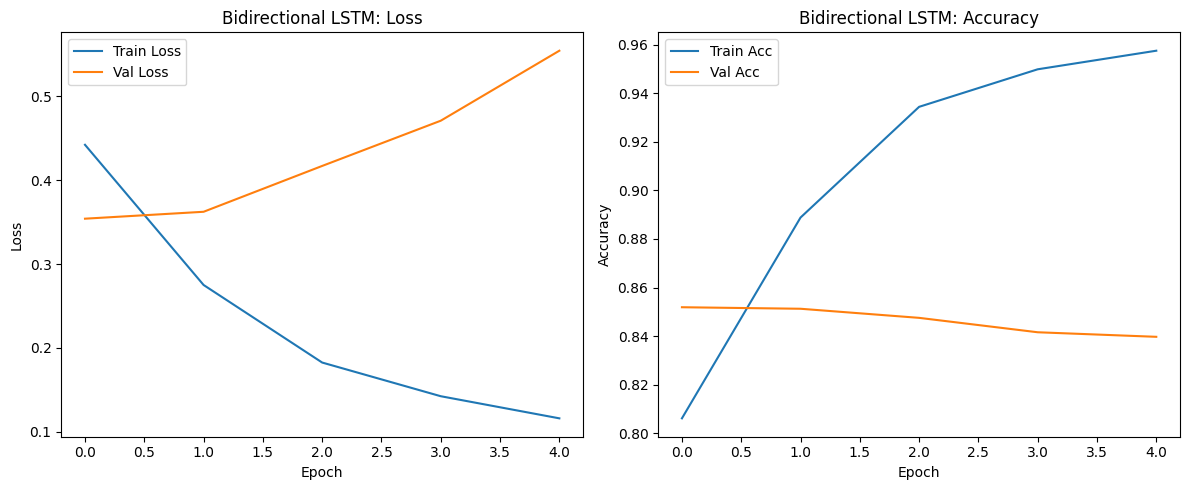

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.7688 - loss: 0.5472 - val_accuracy: 0.7775 - val_loss: 0.5226
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7841 - loss: 0.5135 - val_accuracy: 0.7828 - val_loss: 0.5288
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.7756 - loss: 0.5296 - val_accuracy: 0.7713 - val_loss: 0.5214
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7866 - loss: 0.4902 - val_accuracy: 0.7809 - val_loss: 0.4917
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.8094 - loss: 0.4376 - val_accuracy: 0.8275 - val_loss: 0.4130

Unidirectional LSTM Test Loss: 0.4079
Unidirectional LSTM Test Accuracy: 0.8285

=== Model Comparison ===
Unidirectional LSTM Accuracy:   0.8285
Bidirectional LSTM Accuracy:    0.8428


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv("Reviews.csv")

print("Initial Data Shape:", df.shape)
print(df.head())

# Create Binary Sentiment Labels
df = df.dropna(subset=['Score', 'Text'])
df = df.sample(n=20000, random_state=42)

def encode_sentiment(score):
    return 1 if score >= 4 else 0

df['sentiment'] = df['Score'].apply(encode_sentiment)

print("Class distribution (0=negative, 1=positive):")
print(df['sentiment'].value_counts())

# Tokenize and Pad Sequences
texts = df['Text'].astype(str).tolist()
labels = df['sentiment'].values

vocab_limit = 20000
tokenizer = Tokenizer(num_words=vocab_limit, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Convert text to integer sequences
sequences = tokenizer.texts_to_sequences(texts)

max_length = 100 
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print("X_padded shape:", X_padded.shape)
print("labels shape:", labels.shape)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)
print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")

# Build a Bidirectional LSTM Model

def build_bidirectional_lstm_model(
    vocab_size,  
    embedding_dim,
    input_length
):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=input_length
    ))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    
    return model

vocab_size = vocab_limit 
embedding_dim = 100

bi_lstm_model = build_bidirectional_lstm_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    input_length=max_length
)

print("\n--- Bidirectional LSTM Model Summary ---")
bi_lstm_model.summary()

# Train the Bidirectional LSTM
epochs = 5
batch_size = 64

history_bi = bi_lstm_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluate on Test Set

test_loss_bi, test_acc_bi = bi_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nBidirectional LSTM Test Loss: {test_loss_bi:.4f}")
print(f"Bidirectional LSTM Test Accuracy: {test_acc_bi:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bi.history['loss'], label='Train Loss')
plt.plot(history_bi.history['val_loss'], label='Val Loss')
plt.title('Bidirectional LSTM: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bi.history['accuracy'], label='Train Acc')
plt.plot(history_bi.history['val_accuracy'], label='Val Acc')
plt.title('Bidirectional LSTM: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

def build_unidirectional_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=input_length
    ))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

uni_lstm_model = build_unidirectional_lstm_model(vocab_size, embedding_dim, max_length)
history_uni = uni_lstm_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

test_loss_uni, test_acc_uni = uni_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nUnidirectional LSTM Test Loss: {test_loss_uni:.4f}")
print(f"Unidirectional LSTM Test Accuracy: {test_acc_uni:.4f}")

# Comparison of models
print("\n=== Model Comparison ===")
print(f"Unidirectional LSTM Accuracy:   {test_acc_uni:.4f}")
print(f"Bidirectional LSTM Accuracy:    {test_acc_bi:.4f}")
